In [83]:
from pathlib import Path
Brain_Tumor_MODEL = Path.cwd()          # your "my_project" folder if you open the notebook there
DATA_DIR = Brain_Tumor_MODEL / "Brain_Tumor_Data_Set"


In [84]:
# Expect two subfolders inside datasets
print("Project:",Brain_Tumor_MODEL)
print("Datasets folder exists:", DATA_DIR.exists())
print("Class folders:", [p.name for p in DATA_DIR.iterdir() if p.is_dir()])

Project: c:\Education\MACHINE LEARNING\Models\Brain_Tumor_MODEL
Datasets folder exists: True
Class folders: ['Brain_Tumor', 'Healthy']


In [85]:
import os, random, numpy as np
import torch
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

In [86]:
print(torch.cuda.is_available())

False


##### I make a function of random_seed so My model can use same random values in all model ...

In [87]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

##### This is a type of data formate which we gone a use in Our project ...
* ***.jpg and .jpeg (Joint Photographic Experts Group)***
   - Ye photo ke liye best hai kyunki isse file size choti ho jaati hai, par isme thodi quality loss hoti hai.
* ***.png (Portable Network Graphics)***
   - Ye logo ya graphics ke liye accha hai kyunki isme transparency support hoti hai aur quality bilkul loss nahi hoti.
* ***.bmp (Bitmap)***
   - Ye uncompressed format hai, isliye iski file size bahut badi hoti hai aur iska use ab kam ho gaya hai.
* ***.tif and .tiff (Tagged Image File Format)***
   - Ye high-quality printing aur scanning ke liye best hai kyunki ye saare details ko lossless tarike se store karta hai.

In [88]:
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}



# Function to list all images in a folder and its subfolders
def list_images(folder):
    out = []
    for root,_,files in os.walk(folder):  #  traverse through all subdirectories
        for f in files:
            if os.path.splitext(f)[1].lower() in IMG_EXTS:
                out.append(os.path.join(root,f))
    return out

list_images(DATA_DIR)[:5]

['c:\\Education\\MACHINE LEARNING\\Models\\Brain_Tumor_MODEL\\Brain_Tumor_Data_Set\\Brain_Tumor\\Cancer (1).jpg',
 'c:\\Education\\MACHINE LEARNING\\Models\\Brain_Tumor_MODEL\\Brain_Tumor_Data_Set\\Brain_Tumor\\Cancer (1).png',
 'c:\\Education\\MACHINE LEARNING\\Models\\Brain_Tumor_MODEL\\Brain_Tumor_Data_Set\\Brain_Tumor\\Cancer (1).tif',
 'c:\\Education\\MACHINE LEARNING\\Models\\Brain_Tumor_MODEL\\Brain_Tumor_Data_Set\\Brain_Tumor\\Cancer (10).jpg',
 'c:\\Education\\MACHINE LEARNING\\Models\\Brain_Tumor_MODEL\\Brain_Tumor_Data_Set\\Brain_Tumor\\Cancer (10).tif']

In [89]:
# List all classes (subfolders) in the dataset directory
classes = [d.name for d in DATA_DIR.iterdir() if d.is_dir()]
print("Classes:", classes)


Classes: ['Brain_Tumor', 'Healthy']


In [90]:
# Counting images..
for files in classes:
    paths = list_images(DATA_DIR/files)
    print(f"{files}: {len(paths)} images")


Brain_Tumor: 2513 images
Healthy: 2087 images


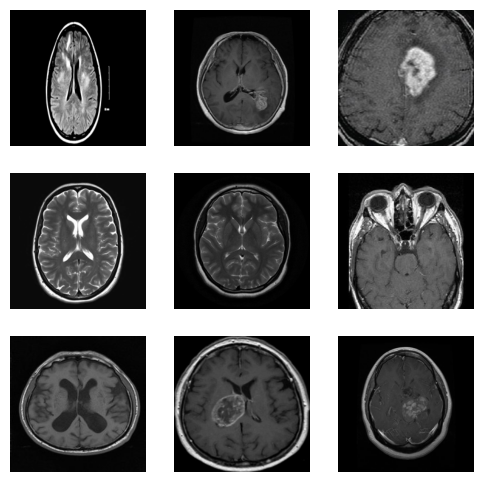

In [91]:
# show up to 9 random images in a grid
all_paths = []
for cls in classes:
    all_paths += list_images(DATA_DIR/cls)[:5]  
random.shuffle(all_paths)
thumbs = []
for p in all_paths[:9]:
    try:
        thumbs.append(Image.open(p).convert("RGB").resize((224,224)))
    except Exception as e:
        print("Bad file:", p, e)

if thumbs:
    cols = 3
    rows = (len(thumbs)+cols-1)//cols
    fig = plt.figure(figsize=(6, 6))
    for i,img in enumerate(thumbs,1):
        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(img)
        ax.axis("off")
    plt.show()

In [92]:
'''
import requests
from pathlib import  Path

# download helper functons from Learn pytorch repository
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists ,skipping download.")
else:
    print("Downloading helper_functions.py from Learn Pytorch repository...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

'''

'\nimport requests\nfrom pathlib import  Path\n\n# download helper functons from Learn pytorch repository\nif Path("helper_functions.py").is_file():\n    print("helper_functions.py already exists ,skipping download.")\nelse:\n    print("Downloading helper_functions.py from Learn Pytorch repository...")\n    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")\n    with open("helper_functions.py", "wb") as f:\n        f.write(request.content)\n\nfrom helper_functions import plot_predictions, plot_decision_boundary\n\n'

# Transforms + ImageFolder
### data augmentation pipeline
Data augmentation pipeline ek process hai jismein existing training data (images) ko naye tarikon se modify kiya jaata hai taaki model ko train karne ke liye aur zyada data mil sake. Isse model alag-alag variations ko pehchanne mein behtar hota hai aur overfitting se bach sakta hai.

In [93]:
img_size = 224  #sets the target image size to 224 pixels.
train_tfms = transforms.Compose([ #image transformations ko ek saath jodkar ek sequence banana hai..
    transforms.Resize(int(img_size*1.14)), # (224 * 1.14 ≈ 255)  geting a slightly larger image
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30), 
    transforms.ToTensor(), # converts the image from a PIL Image or NumPy array into a PyTorch tensor..
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
]) #It uses the mean and standard deviation values of a large dataset (like ImageNet) to normalize the pixel values of each color channel (Red, Green, Blue).


'''
test_image = Image.open("c:\\Education\\MACHINE LEARNING\\Models\\Brain_Tumor_MODEL\\Brain_Tumor_Data_Set\\Brain_Tumor\\Cancer (1).jpg").convert("RGB")
test_tfms = train_tfms(test_image)  # apply the same transformations to the test image
print(test_tfms[:1],"\n",  test_tfms.shape)  # print the first 3 rows and 5 columns of the tensor
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
un_normalized_image = inv_normalize(test_tfms)
final_image = transforms.ToPILImage()(un_normalized_image)
print(un_normalized_image[:1],"\n",  un_normalized_image.shape) 
 # print the first 3 rows and 5 columns of the tensor
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Transformed Image (with Random Flip)")
plt.imshow(final_image)
plt.axis("off")

plt.show() 
'''

'\ntest_image = Image.open("c:\\Education\\MACHINE LEARNING\\Models\\Brain_Tumor_MODEL\\Brain_Tumor_Data_Set\\Brain_Tumor\\Cancer (1).jpg").convert("RGB")\ntest_tfms = train_tfms(test_image)  # apply the same transformations to the test image\nprint(test_tfms[:1],"\n",  test_tfms.shape)  # print the first 3 rows and 5 columns of the tensor\ninv_normalize = transforms.Normalize(\n    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],\n    std=[1/0.229, 1/0.224, 1/0.225]\n)\nun_normalized_image = inv_normalize(test_tfms)\nfinal_image = transforms.ToPILImage()(un_normalized_image)\nprint(un_normalized_image[:1],"\n",  un_normalized_image.shape) \n # print the first 3 rows and 5 columns of the tensor\nplt.figure(figsize=(10, 5))\nplt.subplot(1, 2, 1)\nplt.title("Original Image")\nplt.imshow(img)\nplt.axis("off")\n\nplt.subplot(1, 2, 2)\nplt.title("Transformed Image (with Random Flip)")\nplt.imshow(final_image)\nplt.axis("off")\n\nplt.show() \n'

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

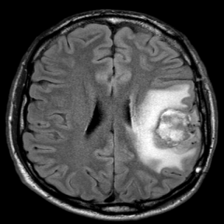

In [94]:
# model evaluation me use k lea ... 
eval_tfms = transforms.Compose([ #image transformations ko ek saath jodkar ek sequence banana hai..
    transforms.Resize(int(img_size*1.14)), 
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])




imag_in_tensor = eval_tfms(Image.open(list_images(DATA_DIR)[1]).convert("RGB"))
print(imag_in_tensor , "\n" , imag_in_tensor.shape)
print(f"3 x 224 x 224 = {3*224*224} parameters")
Image.open(list_images(DATA_DIR)[1]).convert("RGB").resize((224,224))



# Let's ready data for training and 😈 model 

### *datasets.ImageFolder*
  PyTorch function hai jo aapke images ko automatic tareeke se ek dataset object mein badalta hai, jise machine learning model aasani se train kar sake.
  esska kam .
* ke main teen jobs hain:

1. `Image Search and Class Labeling`:
2. `Path Storage`: Yeh har image file ka path uske class label ke saath store karta hai.

3. `Applying Transformations`: Yeh transform parameter mein di gayi list of transformations (jaise ki train_tfms) ko har image par apply karta hai. Isi list mein transforms.ToTensor() shamil hota hai, jo actual mein image ko tensor mein convert karta hai.
 

In [95]:
# Two dataset objects (same files, different transforms)
ds_train_base = datasets.ImageFolder(DATA_DIR, transform=train_tfms)   # all images in DATA_DIR will be transformed using train_tfms
ds_eval_base  = datasets.ImageFolder(DATA_DIR, transform=eval_tfms)    # mean 2513 + 2087 = 4600
# ye function Automatically assigns labels based on the folder names in DATA_DIR.

print(ds_train_base)
print(ds_eval_base)
print(ds_eval_base.classes)
print(ds_eval_base.class_to_idx)  #
 # folder names in label order

Dataset ImageFolder
    Number of datapoints: 4600
    Root location: c:\Education\MACHINE LEARNING\Models\Brain_Tumor_MODEL\Brain_Tumor_Data_Set
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 4600
    Root location: c:\Education\MACHINE LEARNING\Models\Brain_Tumor_MODEL\Brain_Tumor_Data_Set
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               Rando

### Stratified split (train/val/test by image) 🥳finally ...

* `model_selection.train_test_split `  Package
* ` sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None,shuffle=True, stratify=None)[source] `


* Training Set: Kareeb 70% 
* Validation Set: 15%
* Testing Set: 15%

In [96]:
y = np.array(ds_eval_base.targets)
print(y)   #  Socho asa kyu kara ...😉
idx = np.arange(len(y))  # indexes of all images in the dataset

# 15% test, 15% val (you can tweak)
idx_trainval, idx_test = train_test_split(idx, test_size=0.15, random_state=42, stratify=y)
y_trainval = y[idx_trainval]
val_size = 0.15 / (1 - 0.15)  # 0.176... => keeps overall 15% val
idx_train, idx_val = train_test_split(idx_trainval, test_size=val_size, random_state=42, stratify=y_trainval)

len(idx_train), len(idx_val), len(idx_test)


[0 0 0 ... 1 1 1]


(3220, 690, 690)

In [97]:
import pandas as pd

df1 = pd.DataFrame(ds_eval_base.imgs, columns=["image", "label"])
df1.to_csv("full_dataset.csv", index=False)
print(df1)

df = pd.DataFrame({
    "image": [ds_eval_base.imgs[i][0] for i in idx_train ],
    "label": [ds_eval_base.imgs[i][1] for i in idx_train]
})
df.to_csv("train.csv", index=False)
df






                                                  image  label
0     c:\Education\MACHINE LEARNING\Models\Brain_Tum...      0
1     c:\Education\MACHINE LEARNING\Models\Brain_Tum...      0
2     c:\Education\MACHINE LEARNING\Models\Brain_Tum...      0
3     c:\Education\MACHINE LEARNING\Models\Brain_Tum...      0
4     c:\Education\MACHINE LEARNING\Models\Brain_Tum...      0
...                                                 ...    ...
4595  c:\Education\MACHINE LEARNING\Models\Brain_Tum...      1
4596  c:\Education\MACHINE LEARNING\Models\Brain_Tum...      1
4597  c:\Education\MACHINE LEARNING\Models\Brain_Tum...      1
4598  c:\Education\MACHINE LEARNING\Models\Brain_Tum...      1
4599  c:\Education\MACHINE LEARNING\Models\Brain_Tum...      1

[4600 rows x 2 columns]


,image,label
0,c:\Education\MACHINE LEARNING\Models\Brain_Tum...,1
1,c:\Education\MACHINE LEARNING\Models\Brain_Tum...,0
2,c:\Education\MACHINE LEARNING\Models\Brain_Tum...,1
3,c:\Education\MACHINE LEARNING\Models\Brain_Tum...,0
4,c:\Education\MACHINE LEARNING\Models\Brain_Tum...,1
...,...,...
3215,c:\Education\MACHINE LEARNING\Models\Brain_Tum...,0
3216,c:\Education\MACHINE LEARNING\Models\Brain_Tum...,0
3217,c:\Education\MACHINE LEARNING\Models\Brain_Tum...,0
3218,c:\Education\MACHINE LEARNING\Models\Brain_Tum...,1


# Build DataLoaders :


In [ ]:
batch_size = 32
num_workers = 2

train_set = Subset(ds_train_base, idx_train)   # uses train_tfms
val_set   = Subset(ds_eval_base,  idx_val)     # uses eval_tfms
test_set  = Subset(ds_eval_base,  idx_test)    # uses eval_tfms

# Weighted sampler for class imbalance (based on TRAIN labels)
train_labels = [ds_eval_base.targets[i] for i in idx_train]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = np.array([class_weights[t] for t in train_labels], dtype=np.float64)
sampler = WeightedRandomSampler(weights=torch.DoubleTensor(sample_weights),
                                num_samples=len(sample_weights),
                                replacement=True)

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

print(ds_eval_base.classes)
print(class_counts)
print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))



['Brain_Tumor', 'Healthy']
[1759 1461]
Train set size: 3220
Validation set size: 690
Test set size: 690


# Model
ResNet-18 is a 18-layer convolutional neural network (CNN) known for its use of residual blocks to mitigate the vanishing gradient problem, enabling the training of deeper networks.

In [107]:
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# Freeze all conv layers
for p in model.parameters():
    p.requires_grad = False

# Replace classifier head
in_feats = model.fc.in_features
model.fc = torch.nn.Linear(in_feats, 2)   # 2 classes: [Brain_Tumor, Healthy] (alphabetical order)
model = model.to(device)



# loss funtion and optimizer....
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)  # only head


In [108]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, loader):
    model.eval() # Set the model to evaluation mode
    preds, gts = [], []

    # Disable gradient calculations for faster inference
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = torch.argmax(logits, dim=1)

            
            preds.extend(pred.cpu().numpy())
            gts.extend(y.cpu().numpy())

    acc = accuracy_score(gts, preds)
    pr, rc, f1, _ = precision_recall_fscore_support(gts, preds, average="binary", zero_division=0)
    
    return {"acc": acc, "prec": pr, "rec": rc, "f1": f1}, (np.array(gts), np.array(preds))

In [109]:
from torchvision import datasets
dataset = datasets.ImageFolder("Brain_Tumor_Data_Set")
print(dataset.classes)
classes = dataset.classes  



['Brain_Tumor', 'Healthy']


# Train 

In [110]:
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5

best_f1 = -1.0

for epoch in range(1, epochs + 1):

    model.train()

    for x, y in train_loader:
    
        x, y = x.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model(x)

        # 2. Calculate loss
        loss = criterion(y_logits, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward (backpropagation)
        loss.backward()

        # 5. Optimizer step (gradient descent)
        optimizer.step()

    ### Evaluation / Testing
    model.eval()
    with torch.inference_mode():
        # Evaluate the model on the validation set using the provided evaluate function
        metrics, _ = evaluate(model, val_loader)

    # Print out what's happenin'
    print(f"Epoch {epoch} | val_acc {metrics['acc']:.3f}  val_f1 {metrics['f1']:.3f}")

    # Check if the current F1 score is better than the best recorded
    if metrics["f1"] > best_f1:
        best_f1 = metrics["f1"]
        torch.save(model.state_dict(), "best_frozen_resnet18.pt")
        print("  ↳ saved: best_frozen_resnet18.pt")

print("\nTraining complete.")

'''

'\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\ntorch.manual_seed(42)\ntorch.cuda.manual_seed(42)\n\nepochs = 5\n\nbest_f1 = -1.0\n\nfor epoch in range(1, epochs + 1):\n\n    model.train()\n\n    for x, y in train_loader:\n    \n        x, y = x.to(device), y.to(device)\n\n        # 1. Forward pass\n        y_logits = model(x)\n\n        # 2. Calculate loss\n        loss = criterion(y_logits, y)\n\n        # 3. Optimizer zero grad\n        optimizer.zero_grad()\n\n        # 4. Loss backward (backpropagation)\n        loss.backward()\n\n        # 5. Optimizer step (gradient descent)\n        optimizer.step()\n\n    ### Evaluation / Testing\n    model.eval()\n    with torch.inference_mode():\n        # Evaluate the model on the validation set using the provided evaluate function\n        metrics, _ = evaluate(model, val_loader)\n\n    # Print out what\'s happenin\'\n    print(f"Epoch {epoch} | val_acc {metrics[\'acc\']:.3f}  val_f1 {metrics[\'f1\']:.3f}")\n\n 

In [111]:
# Set the number of epochs
epochs =  5

best_f1 = -1.0

# Build training and evaluation loop
for epoch in range(1, epochs + 1):
    ### Training
    model.train()

    # Initialize variables to track training metrics for the epoch
    train_loss_sum = 0
    train_acc_sum = 0
    num_batches = 0

    # Loop through the training batches
    for x, y in train_loader:
        # Put data to target device
        x, y = x.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model(x)
        
        # 2. Calculate loss and accuracy
        loss = criterion(y_logits, y)
        acc = (y_logits.argmax(dim=1) == y).float().mean()

        # Update the running sums
        train_loss_sum += loss.item()
        train_acc_sum += acc.item()
        num_batches += 1

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward (backpropagation)
        loss.backward()

        # 5. Optimizer step (gradient descent)
        optimizer.step()

    # Calculate average training metrics for the epoch
    avg_train_loss = train_loss_sum / num_batches
    avg_train_acc = train_acc_sum / num_batches

    ### Evaluation / Testing
    model.eval()
    with torch.inference_mode():
        # Evaluate the model on the validation set
        metrics, _ = evaluate(model, val_loader)

    # Print out what's happenin'
    print(f"Epoch {epoch} | val_acc {metrics['acc']:.3f}  val_f1 {metrics['f1']:.3f}")

    # Check if the current F1 score is better than the best recorded
    if metrics["f1"] > best_f1:
        best_f1 = metrics["f1"]
        torch.save(model.state_dict(), "best_frozen_resnet18.pt")
        print("  ↳ saved: best_frozen_resnet18.pt")

c:\Users\Asus\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1 | val_acc 0.823  val_f1 0.795
  ↳ saved: best_frozen_resnet18.pt


c:\Users\Asus\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2 | val_acc 0.846  val_f1 0.834
  ↳ saved: best_frozen_resnet18.pt


c:\Users\Asus\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3 | val_acc 0.871  val_f1 0.851
  ↳ saved: best_frozen_resnet18.pt


c:\Users\Asus\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4 | val_acc 0.861  val_f1 0.842


c:\Users\Asus\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5 | val_acc 0.864  val_f1 0.850


## Final test evaluation

In [112]:
# load best and test
model.load_state_dict(torch.load("best_frozen_resnet18.pt", map_location=device))
test_metrics, (y_true, y_pred) = evaluate(model, test_loader)
print("TEST:", test_metrics)

cm = confusion_matrix(y_true, y_pred)
cm



c:\Users\Asus\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TEST: {'acc': 0.8536231884057971, 'prec': 0.875886524822695, 'rec': 0.7891373801916933, 'f1': 0.8302521008403362}


array([[342,  35],
       [ 66, 247]], dtype=int64)

# Single-image prediction helper

In [ ]:



idx = 0
label, prob = predict_image([idx], model, transform, classes)

print(f"Prediction → {label} ({prob:.2f})")


Total images: 2081
Selected image: Brain_Tumor_Data_Set/Healthy\Not Cancer  (100).jpg
Prediction → Healthy (0.81)


In [135]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

# ----- Load Model -----
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("best_frozen_resnet18.pt", map_location="cpu"))
model.eval()

# ----- Classes -----
classes = ["Brain_Tumor", "Healthy"]

# ----- Transform -----
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ----- Make Lists -----
tumor_dir = "Brain_Tumor_Data_Set/Brain_Tumor"
healthy_dir = "Brain_Tumor_Data_Set/Healthy"

tumor_images = [os.path.join(tumor_dir, f) for f in os.listdir(tumor_dir) if f.endswith(('.jpg','.png'))]
healthy_images = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if f.endswith(('.jpg','.png'))]

print("Tumor Images:", len(tumor_images))
print("Healthy Images:", len(healthy_images))

# ----- Prediction Function -----
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        out = model(img_t)
        prob = torch.nn.functional.softmax(out, dim=1)[0]
        pred = torch.argmax(prob).item()
    return classes[pred], prob[pred].item()


print("\nTesting a tumor image:")
print(tumor_images[0], "->", predict_image(tumor_images[0]))

print("\nTesting a healthy image:")
print(healthy_images[0], "->", predict_image(healthy_images[10]))


Tumor Images: 2359
Healthy Images: 2075

Testing a tumor image:
Brain_Tumor_Data_Set/Brain_Tumor\Cancer (1).jpg -> ('Brain_Tumor', 0.8740820288658142)

Testing a healthy image:
Brain_Tumor_Data_Set/Healthy\Not Cancer  (1).jpg -> ('Healthy', 0.9579972624778748)
